In [1]:
import numpy as np
import pandas as pd
from hlda_utils import *
from hlda_final import *

from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import io
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
###########################################
# LOAD & PREPROCESS 20 NEWSGROUPS
###########################################

dataset = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))
all_docs = dataset.data
all_labels = dataset.target

print("Total raw documents in 20newsgroups (train):", len(all_docs))

_, _, vocab, word2idx, idx2word, corpus_indices = \
    full_preprocessing_pipeline(all_docs, all_labels, 
                                min_word_length=2, 
                                min_freq=100)

print(f"Vocabulary size after min_freq=100: {len(vocab)}")

Total raw documents in 20newsgroups (train): 11314
Documents after filtering: 10999
Vocabulary size: 1998
Preprocessing complete.
Vocabulary size after min_freq=100: 1998


In [3]:
###########################################
# 1) SELECT 500 SUITABLY-LONG DOCS
###########################################

selected_corpus = []
selected_count = 0
for doc in corpus_indices:
    if len(doc) >= 100:
        selected_corpus.append(doc)
        selected_count += 1
        if selected_count == 500:
            break

print(f"Number of selected documents: {len(selected_corpus)} (each >= 100 tokens).")


Number of selected documents: 500 (each >= 100 tokens).


## Synthetic data test

In [72]:
def js_matching(model1, model1_topic_id, model2, model2_parent_topic_id, eps=1e-12):
    """
    Compare a given topic (node) from the ground truth model (model1) with every topic (node)
    among the children of a specified parent node in model2 by computing the 
    Jensen-Shannon divergence (JSD) between their distributions. Return the candidate node 
    id with the lowest JSD score along with that score.
    
    Parameters
    ----------
    model1 : hLDA
        The hLDA model considered as the ground truth.
    model1_topic_id : int
        The topic (node) id in the ground truth model to compare.
    model2 : hLDA
        The hLDA model to be compared against.
    model2_parent_topic_id : int
        The topic (node) id in model2 whose children will be used as candidate nodes for matching.
    eps : float, optional
        A small constant added to avoid division by zero in divergence calculations.
    
    Returns
    -------
    best_node_id : int
        The node id from the children of the specified parent in model2 with the lowest JSD score.
    best_js_score : float
        The lowest Jensen-Shannon divergence score.
    """
    # Find the target node in model1.
    target_node = None
    for node in model1.traverse_tree():
        if node.node_index == model1_topic_id:
            target_node = node
            break
    if target_node is None:
        raise ValueError(f"Ground truth topic {model1_topic_id} not found in model1.")
    target_level = target_node.level_id

    # Find the specified parent node in model2.
    parent_node = None
    for node in model2.traverse_tree():
        if node.node_index == model2_parent_topic_id:
            parent_node = node
            break
    if parent_node is None:
        raise ValueError(f"Parent topic {model2_parent_topic_id} not found in model2.")

    best_node_id = None
    best_js_score = np.inf 

    # Iterate only over the children of the specified parent.
    for candidate in parent_node.children:
        # Optionally, ensure that candidate is at the same level as the target node.
        if candidate.level_id != target_level:
            continue
        js_score = jensen_shannon_divergence(model1, model1_topic_id, model2, candidate.node_index, eps=eps)
        if js_score < best_js_score:
            best_js_score = js_score
            best_node_id = candidate.node_index

    return best_node_id, best_js_score

In [4]:
ground_truth_model = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=1.0,
    eta=0.1,  
    seed=42,
    verbose=False
)

time = ground_truth_model.gibbs_sampling(
    iterations=5000,
    display_interval=5000,
    top_n=5
)

Starting hierarchical LDA sampling...
Iteration 5000
Topic Node 0 (level=0, docs=500): to(2214), it(1679), is(1625), you(1553), that(1310)
    Topic Node 1 (level=1, docs=260): the(3467), of(1595), in(1084), and(1073), to(952)
        Topic Node 2 (level=2, docs=195): the(1943), of(1230), and(769), that(746), to(737)
        Topic Node 6 (level=2, docs=3): period(42), pp(37), play(30), power(29), pt(27)
        Topic Node 11 (level=2, docs=30): the(205), of(54), is(50), chip(49), and(49)
        Topic Node 14 (level=2, docs=10): the(85), of(85), and(79), turkish(31), presid(21)
        Topic Node 72 (level=2, docs=6): of(48), and(46), for(36), in(29), sequenc(24)
        Topic Node 286 (level=2, docs=13): the(26), run(22), program(21), have(18), window(18)
        Topic Node 8262 (level=2, docs=3): may(20), ma(16), june(13), april(9), me(9)
    Topic Node 3 (level=1, docs=166): the(2282), of(1048), and(644), in(573), to(550)
        Topic Node 4 (level=2, docs=82): the(973), and(690), 

In [8]:
doc_lengths = [len(doc) for doc in selected_corpus]
avg_length = int(np.mean(doc_lengths))
print(f"Average document length in selected corpus = {avg_length} tokens")

# Generate 500 synthetic documents using the ground truth model
num_synth_docs = 500
synth_corpus = ground_truth_model.generate_synthetic_corpus(
    num_docs=num_synth_docs,
    words_per_doc=avg_length,
    alpha_dir=10.0,   
    rng=None
)

Average document length in selected corpus = 321 tokens
Generated 500 synthetic documents, each ~321 words


In [9]:
synthetic_model = hLDA(
    corpus=synth_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

time_synth = synthetic_model.gibbs_sampling(
    iterations=5000,
    display_interval=5000,
    top_n=5,
    show=True
)
print(f"Synthetic-data model trained in ~{time_synth} minutes.\n")

Starting hierarchical LDA sampling...
Iteration 5000
Topic Node 0 (level=0, docs=500): the(3603), to(2635), and(1782), is(1695), it(1647)
    Topic Node 1 (level=1, docs=433): the(3506), of(2216), and(1355), in(1268), to(1134)
        Topic Node 2 (level=2, docs=41): vote(123), your(73), will(65), be(65), the(58)
        Topic Node 3 (level=2, docs=25): the(156), of(130), and(115), turkish(51), presid(37)
        Topic Node 6 (level=2, docs=331): the(2607), is(1198), of(905), to(821), that(615)
        Topic Node 9 (level=2, docs=19): period(137), pp(111), pt(94), play(92), power(82)
        Topic Node 13 (level=2, docs=11): none(41), kill(18), of(18), were(17), attack(15)
        Topic Node 22 (level=2, docs=6): lo(21), lead(16), cub(15), pitcher(14), stl(13)
    Topic Node 4 (level=1, docs=8): ad(8), two(7), pressur(7), were(5), issu(5)
        Topic Node 23 (level=2, docs=8): the(83), good(53), veri(48), excel(47), cover(26)
    Topic Node 7 (level=1, docs=18): the(219), of(91), in(

In [40]:
print("\n--- Ground Truth Model Structure (brief) ---")
ground_truth_model.exhibit_topics(top_n=5, structure=True)

print("\n--- New Synthetic Model Structure (brief) ---")
synthetic_model.exhibit_topics(top_n=5, structure=True)


--- Ground Truth Model Structure (brief) ---
Topic Node 0 (level=0, children=4)
  Topic Node 1 (level=1, children=7)
    Topic Node 2 (level=2, children=0)
    Topic Node 6 (level=2, children=0)
    Topic Node 11 (level=2, children=0)
    Topic Node 14 (level=2, children=0)
    Topic Node 72 (level=2, children=0)
    Topic Node 286 (level=2, children=0)
    Topic Node 8262 (level=2, children=0)
  Topic Node 3 (level=1, children=8)
    Topic Node 4 (level=2, children=0)
    Topic Node 5 (level=2, children=0)
    Topic Node 15 (level=2, children=0)
    Topic Node 51 (level=2, children=0)
    Topic Node 1079 (level=2, children=0)
    Topic Node 6676 (level=2, children=0)
    Topic Node 8787 (level=2, children=0)
    Topic Node 8859 (level=2, children=0)
  Topic Node 7 (level=1, children=4)
    Topic Node 8 (level=2, children=0)
    Topic Node 9 (level=2, children=0)
    Topic Node 201 (level=2, children=0)
    Topic Node 8864 (level=2, children=0)
  Topic Node 12 (level=1, children=8)
  

In [38]:
# Generate 100 synthetic documents using the ground truth model
num_synth_docs = 100
synth_corpus1 = ground_truth_model.generate_synthetic_corpus(
    num_docs=num_synth_docs,
    words_per_doc=avg_length,
    alpha_dir=10.0,   # or any other Dirichlet parameter you prefer
    rng=None          # uses the model's default RNG
)


In [42]:
synthetic_model1 = hLDA(
    corpus=synth_corpus1,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

time_synth1 = synthetic_model1.gibbs_sampling(
    iterations=5000,
    display_interval=5000,
    top_n=5,
    show=True
)
print(f"Synthetic-data model trained in ~{time_synth1} minutes.\n")

Starting hierarchical LDA sampling...
Iteration 5000
Topic Node 0 (level=0, docs=100): the(1959), of(798), to(620), and(601), in(496)
    Topic Node 1 (level=1, docs=42): to(147), you(130), have(109), it(98), and(74)
        Topic Node 2 (level=2, docs=5): period(32), power(29), pp(27), play(26), pt(17)
        Topic Node 3 (level=2, docs=6): max(189), ql(36), giz(21), bj(18), bhj(18)
        Topic Node 6 (level=2, docs=10): den(38), doug(21), good(18), excel(16), veri(11)
        Topic Node 9 (level=2, docs=11): shuttl(27), mission(21), orbit(18), space(15), launch(14)
        Topic Node 13 (level=2, docs=10): washington(24), street(18), new(17), dc(16), ny(15)
    Topic Node 7 (level=1, docs=55): to(205), you(176), have(158), it(140), do(90)
        Topic Node 8 (level=2, docs=18): the(63), that(21), he(21), argument(19), pitcher(18)
        Topic Node 12 (level=2, docs=21): of(67), none(21), way(15), use(12), health(12)
        Topic Node 15 (level=2, docs=16): vote(23), window(18),

In [43]:
print("\n--- Ground Truth Model Structure (brief) ---")
ground_truth_model.exhibit_topics(top_n=5, structure=True)

print("\n--- New Synthetic Model Structure (brief) ---")
synthetic_model1.exhibit_topics(top_n=5, structure=True)


--- Ground Truth Model Structure (brief) ---
Topic Node 0 (level=0, children=4)
  Topic Node 1 (level=1, children=7)
    Topic Node 2 (level=2, children=0)
    Topic Node 6 (level=2, children=0)
    Topic Node 11 (level=2, children=0)
    Topic Node 14 (level=2, children=0)
    Topic Node 72 (level=2, children=0)
    Topic Node 286 (level=2, children=0)
    Topic Node 8262 (level=2, children=0)
  Topic Node 3 (level=1, children=8)
    Topic Node 4 (level=2, children=0)
    Topic Node 5 (level=2, children=0)
    Topic Node 15 (level=2, children=0)
    Topic Node 51 (level=2, children=0)
    Topic Node 1079 (level=2, children=0)
    Topic Node 6676 (level=2, children=0)
    Topic Node 8787 (level=2, children=0)
    Topic Node 8859 (level=2, children=0)
  Topic Node 7 (level=1, children=4)
    Topic Node 8 (level=2, children=0)
    Topic Node 9 (level=2, children=0)
    Topic Node 201 (level=2, children=0)
    Topic Node 8864 (level=2, children=0)
  Topic Node 12 (level=1, children=8)
  

In [45]:
# Generate 100 synthetic documents using the ground truth model
num_synth_docs = 100
synth_corpus2 = ground_truth_model.generate_synthetic_corpus(
    num_docs=num_synth_docs,
    words_per_doc=avg_length,
    alpha_dir=10.0,   
    rng=None
)

synthetic_model2 = hLDA(
    corpus=synth_corpus2,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

time_synth2 = synthetic_model2.gibbs_sampling(
    iterations=5000,
    display_interval=5000,
    top_n=5,
    show=True
)
print(f"Synthetic-data model trained in ~{time_synth2} minutes.\n")

Starting hierarchical LDA sampling...
Iteration 5000
Topic Node 0 (level=0, docs=100): to(492), is(480), it(451), that(426), for(382)
    Topic Node 1 (level=1, docs=60): the(1137), of(557), and(425), in(257), to(256)
        Topic Node 2 (level=2, docs=8): max(97), father(33), ql(25), not(23), son(21)
        Topic Node 3 (level=2, docs=11): good(57), veri(36), excel(34), miss(32), cover(26)
        Topic Node 6 (level=2, docs=19): period(52), pp(48), play(37), pt(35), no(25)
        Topic Node 9 (level=2, docs=13): from(25), kill(17), by(14), were(13), none(12)
        Topic Node 13 (level=2, docs=9): den(52), doug(28), doubl(8), help(7), symbol(6)
    Topic Node 7 (level=1, docs=40): the(829), and(319), of(309), to(187), in(153)
        Topic Node 8 (level=2, docs=17): of(38), program(20), are(16), run(16), or(15)
        Topic Node 12 (level=2, docs=11): will(28), orbit(18), mission(15), shuttl(15), launch(14)
        Topic Node 19 (level=2, docs=12): my(15), power(15), game(13), d

| **Model**       | **Total Nodes** | **Nodes at Level 2** | **Nodes at Level 3** | **No. of Documents** | **Number of Iter** | **Dataset Used**    |
|-----------------|-----------------|----------------------|-----------------|----------------|----------------------|----------------------|
| "Ground Truth"    | 32              | 4                    | 27                   | 500                  | 5000          | selected_corpus |
| Synthetic      | 18              | 5                    | 12                   | 500                  | 5000          | synth_corpus |
| Synthetic 1     | 30              | 6                    | 22                   | 100                  | 5000          | synth_corpus1 |
| Synthetic 2     |               |                     |                   | 100                  | 5000          | synth_corpus2 |

### 1.1 Semantic tree comparison

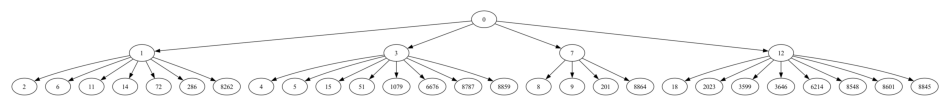

In [28]:
visualise_tree(ground_truth_model,False)

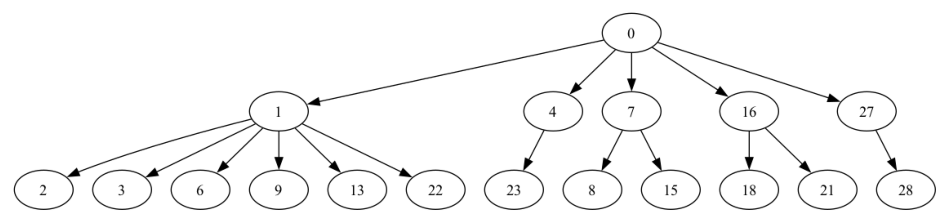

In [35]:
visualise_tree(synthetic_model,False)

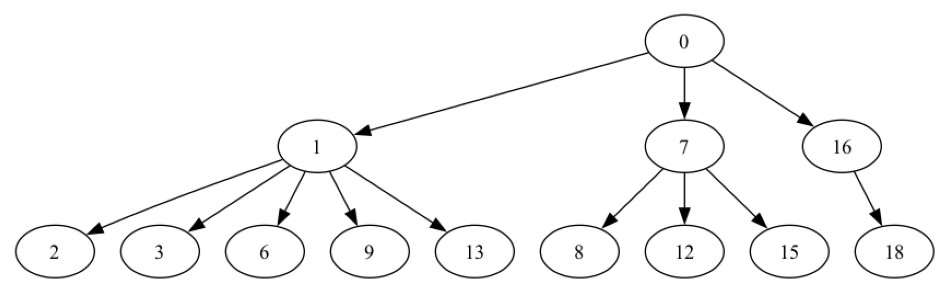

In [44]:
visualise_tree(synthetic_model1,False)

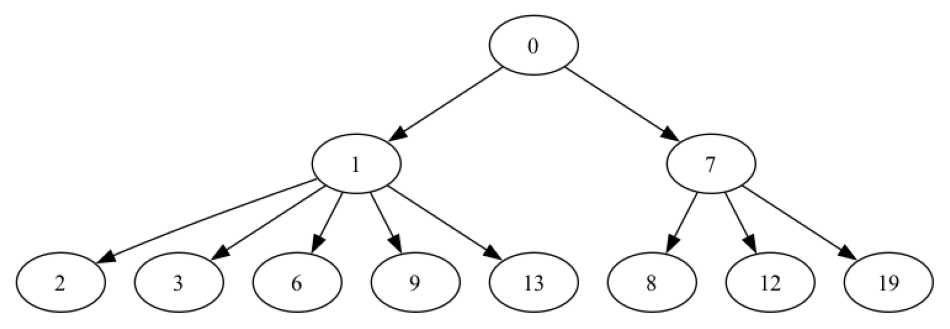

In [46]:
visualise_tree(synthetic_model2, False)

### 1.2 Topic similarity

#### Ground-truth vs synthetic 

In [57]:
jsd_root_score = jensen_shannon_divergence(ground_truth_model, 0, synthetic_model, 0)
print("Jensen-Shannon Divergence:", jsd_score)

Jensen-Shannon Divergence: 0.11597908508192835


High similarity at the root

In [73]:
jsd_score = jensen_shannon_divergence(ground_truth_model, 1, synthetic_model, 1)
print("Jensen-Shannon Divergence:", jsd_score)

Jensen-Shannon Divergence: 0.18908510345009022


In [93]:
best_id, best_score = js_matching(synthetic_model, 27, ground_truth_model, 0)
print(f"Best matching candidate is node {best_id} with a JSD score of {best_score}")

Best matching candidate is node 1 with a JSD score of 0.5554256345330583


In [77]:
best_id, best_score = js_matching(synthetic_model, 2, ground_truth_model, 3)
print(f"Test node {best_id} has the best match with the highest JSD score: {best_score}")

Test node 6676 has the best match with the highest JSD score: 0.14360089644273424


#### **Choosing Metrics for Comparing hLDA Results**
When evaluating **hierarchical topic models (hLDA) across multiple runs**, we need metrics to compare:
1. **Topic similarity** (distributional comparison of word probabilities).
2. **Tree structure similarity** (hierarchical consistency between runs).

---

###### **1. Comparing Topic Similarity: Jensen-Shannon Divergence (JSD)**
To compare topics across runs, if we treat them as **probability distributions over words**, a natural choice is to measure their **divergence**. The two most common candidates are:

###### **Kullback-Leibler (KL) Divergence**
The **KL divergence** measures how one probability distribution differs from another:

$$
D_{KL}(P || Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}
$$

###### **Jensen-Shannon Divergence (JSD) - Alternative**
JSD **fixes KL’s asymmetry** and handles missing probabilities by introducing a midpoint distribution:

$$
JSD(P || Q) = \frac{1}{2} D_{KL}(P || M) + \frac{1}{2} D_{KL}(Q || M)
$$

where 

$$
M = \frac{P + Q}{2}
$$

**Properties of JSD:**
- **Symmetric:**  
  $$ JSD(P || Q) = JSD(Q || P) $$
- **Bounded:**  
  $$ 0 \leq JSD(P, Q) \leq log2 $$  
  if the log is 2 based.
- **Always defined** even when \( P(i) \) or \( Q(i) \) contains zeros.

Since we are comparing topics **across different runs**, where distributions may change unpredictably, **JSD is the better choice as opposed to KL divergence**.

---

##### **2. Comparing Tree Structure Similarity**
Since hLDA produces **hierarchical topic trees**, we need a way to measure **structural consistency** across runs. Several options exist:

###### **Tree Edit Distance (Best for Fine-Grained Comparisons)**
- Measures the **minimum number of node insertions, deletions, and reassignments** to transform one tree into another.
- **Good for small trees** where subtle differences matter.

###### **Robinson–Foulds (RF) Metric (Best for Large-Scale Comparisons)**
$$
RF(T_1, T_2) = |S_1 \setminus S_2| + |S_2 \setminus S_1|
$$

- Measures differences in **bipartitions (splits)** between two trees.
- **Good for high-level structural comparisons**, but ignores fine details.